<a href="https://colab.research.google.com/github/Fahad-Blog/Data-Science-Portfolio/blob/main/Marketing_Mix_Modelling_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
# Work with times
import datetime

# Import additional libraries for statistical analysis
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor

In [10]:
df = pd.read_csv('/content/sample_data/marketing_mix.csv')

In [11]:
df.head()

,Date,TikTok,Facebook,Google Ads,Sales
0,1/7/2018,13528.1,0.00,0.00,9779.80
1,1/14/2018,0.0,5349.65,2218.93,13245.19
2,1/21/2018,0.0,4235.86,2046.96,12022.66
3,1/28/2018,0.0,3562.21,0.00,8846.95
4,2/4/2018,0.0,0.00,2187.29,9797.07


In [12]:
print(df.describe())
print(df.isnull().sum())

             TikTok     Facebook   Google Ads         Sales
count    200.000000   200.000000   200.000000    200.000000
mean    2946.207650  2213.585050  1520.722550  10668.141500
std     4749.646908  2505.967886   870.764354   2700.706683
min        0.000000     0.000000     0.000000   4532.330000
25%        0.000000     0.000000  1657.195000   8396.942500
50%        0.000000     0.000000  1918.990000  10853.105000
75%     7938.527500  4624.027500  2069.767500  12566.995000
max    13901.550000  7696.220000  2518.880000  17668.340000
Date          0
TikTok        0
Facebook      0
Google Ads    0
Sales         0
dtype: int64


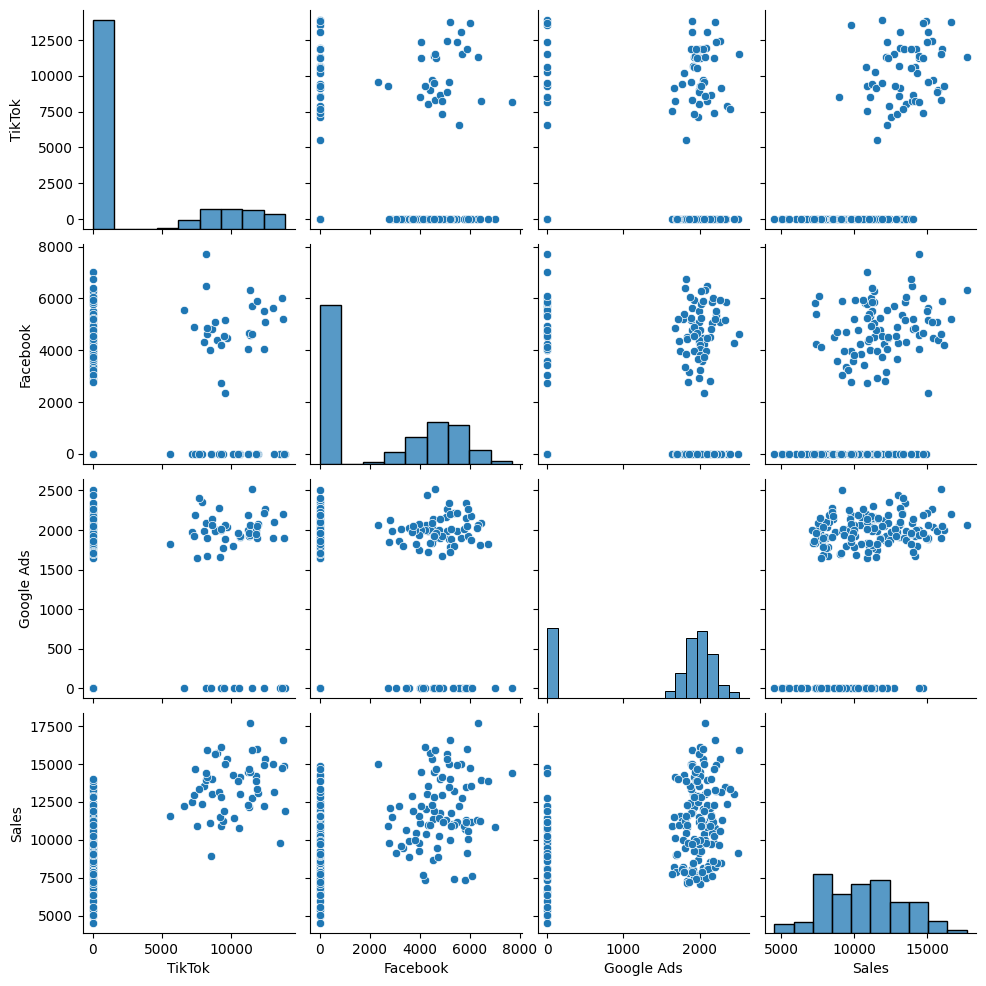

CPU times: user 3.06 s, sys: 35.1 ms, total: 3.1 s
Wall time: 4.06 s


In [13]:
%%time
sns.pairplot(df)
plt.show()

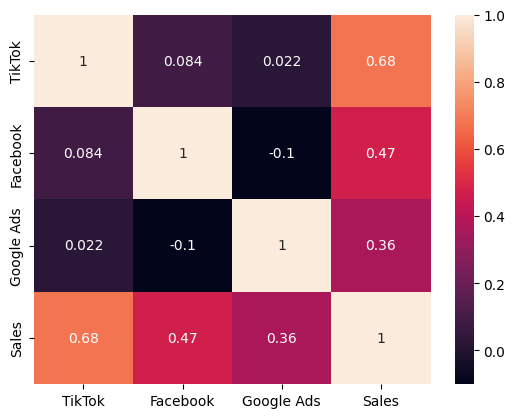

CPU times: user 280 ms, sys: 8.44 ms, total: 289 ms
Wall time: 497 ms


In [14]:
%%time
df_variables = df.loc[:, df.columns != 'Date']
# Calculate the correlation matrix to examine relationships between numerical variables
corr = df_variables.corr()
# Visualize the correlation matrix using a heatmap for better interpretability
sns.heatmap(corr, annot=True)
# Display the heatmap
plt.show()

In [15]:
%%time
# Convert 'Date' to datetime and create extra features
df['Date'] = pd.to_datetime(df['Date'])

# Extract features from the 'Date' column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Drop the original 'Date' columnSort by date to ensure correct ordering for lag/rolling
#    and reset index to maintain monotonic index for shifting

#    It's critical that the DataFrame is ordered by actual calendar date
#    so that lagged features correspond to previous rows in time.
df = df.sort_values('Date').reset_index(drop=True)

# Display the first few rows of the DataFrame to inspect the data

print(df.head())
# Data distribution of the DataFrame
print(df.describe())

        Date   TikTok  Facebook  Google Ads     Sales  Year  Month  Day  \
0 2018-01-07  13528.1      0.00        0.00   9779.80  2018      1    7   
1 2018-01-14      0.0   5349.65     2218.93  13245.19  2018      1   14   
2 2018-01-21      0.0   4235.86     2046.96  12022.66  2018      1   21   
3 2018-01-28      0.0   3562.21        0.00   8846.95  2018      1   28   
4 2018-02-04      0.0      0.00     2187.29   9797.07  2018      2    4   

   WeekOfYear  
0           1  
1           2  
2           3  
3           4  
4           5  
                      Date        TikTok     Facebook   Google Ads  \
count                  200    200.000000   200.000000   200.000000   
mean   2019-12-04 12:00:00   2946.207650  2213.585050  1520.722550   
min    2018-01-07 00:00:00      0.000000     0.000000     0.000000   
25%    2018-12-21 06:00:00      0.000000     0.000000  1657.195000   
50%    2019-12-04 12:00:00      0.000000     0.000000  1918.990000   
75%    2020-11-16 18:00:00   7938

In [16]:
%%time
#    Here, we create lags for 1-week, 2-week, and 3-week delays
lag_weeks = [1, 2, 3]
for lag in lag_weeks:
    df[f'TikTok_lag_{lag}'] = df['TikTok'].shift(lag)
    df[f'Facebook_lag_{lag}'] = df['Facebook'].shift(lag)
    df[f'GoogleAds_lag_{lag}'] = df['Google Ads'].shift(lag)
    df[f'Sales_lag_{lag}'] = df['Sales'].shift(lag)

CPU times: user 7.3 ms, sys: 0 ns, total: 7.3 ms
Wall time: 11.3 ms


In [18]:
%%time
#    Edit below number to experiment with other window sizes
rolling_window = 3

df['TikTok_roll_mean_3w'] = df['TikTok'].rolling(window=rolling_window).mean().shift(1)
df['Facebook_roll_mean_3w'] = df['Facebook'].rolling(window=rolling_window).mean().shift(1)
df['GoogleAds_roll_mean_3w'] = df['Google Ads'].rolling(window=rolling_window).mean().shift(1)
df['Sales_roll_mean_3w'] = df['Sales'].rolling(window=rolling_window).mean().shift(1)

#  After creating lagged and rolling features, drop rows with NaN caused by shifting
#    This ensures that all features for modeling have valid, non-null values.
df = df.dropna().reset_index(drop=True)

# Display the first few rows after feature creation
print("DataFrame with lagged & rolling features:\n")
print(df.head())

print(df.describe())

DataFrame with lagged & rolling features:

        Date   TikTok  Facebook  Google Ads     Sales  Year  Month  Day  \
0 2018-01-28     0.00   3562.21        0.00   8846.95  2018      1   28   
1 2018-02-04     0.00      0.00     2187.29   9797.07  2018      2    4   
2 2018-02-11  8045.44   4310.55     1992.98  13527.65  2018      2   11   
3 2018-02-18     0.00      0.00     2253.02   9635.43  2018      2   18   
4 2018-02-25  9697.29   4478.81     2042.30  15355.11  2018      2   25   

   WeekOfYear  TikTok_lag_1  ...  GoogleAds_lag_2  Sales_lag_2  TikTok_lag_3  \
0           4          0.00  ...          2218.93     13245.19       13528.1   
1           5          0.00  ...          2046.96     12022.66           0.0   
2           6          0.00  ...             0.00      8846.95           0.0   
3           7       8045.44  ...          2187.29      9797.07           0.0   
4           8          0.00  ...          1992.98     13527.65           0.0   

   Facebook_lag_3  Google

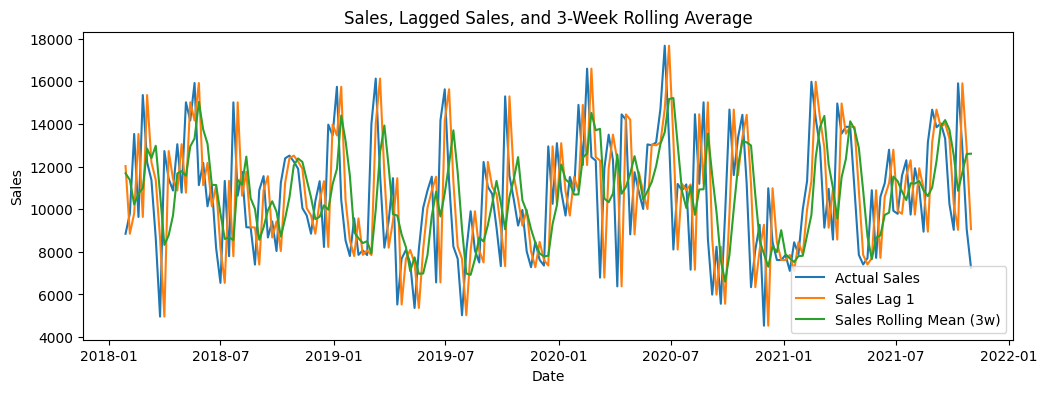

CPU times: user 684 ms, sys: 8.87 ms, total: 692 ms
Wall time: 893 ms


In [19]:
%%time
#     Plot Sales, Sales_lag_1, and Sales_roll_mean_3w over time
plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Sales'], label='Actual Sales')
plt.plot(df['Date'], df['Sales_lag_1'], label='Sales Lag 1')
plt.plot(df['Date'], df['Sales_roll_mean_3w'], label='Sales Rolling Mean (3w)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales, Lagged Sales, and 3-Week Rolling Average')
plt.show()

In [20]:
%%time
#     Retain original TV channels + lagged and rolling variables + temporal features
feature_cols = [
    'TikTok', 'Facebook', 'Google Ads',  # original ad spend
    'Year', 'Month', 'WeekOfYear',        # temporal features
]
# Append lag features
for lag in lag_weeks:
    feature_cols += [f'TikTok_lag_{lag}', f'Facebook_lag_{lag}', f'GoogleAds_lag_{lag}']
# Append rolling features
feature_cols += ['TikTok_roll_mean_3w', 'Facebook_roll_mean_3w', 'GoogleAds_roll_mean_3w']

X = df[feature_cols]
y = df['Sales']

# Train-test split. For simplicity, use a random split but set shuffle=False to respect time ordering
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

CPU times: user 4.8 ms, sys: 0 ns, total: 4.8 ms
Wall time: 35.3 ms


In [21]:
%%time
# Helper function for GridSearchCV FOR RIDGE, LASSO, RANDOM FOREST, XGBOOST
def run_grid_search(model, param_grid, X_tr, y_tr, cv_splits=5, scoring='neg_mean_squared_error'):
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=tscv,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_tr, y_tr)
    return grid_search

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.48 µs


In [22]:
%%time
# 13) Linear Regression (no hyperparams, baseline)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
print(f"Linear Regression - MSE: {mean_squared_error(y_test, y_pred_lin):.2f}, R2: {r2_score(y_test, y_pred_lin):.3f}")

# 14) Ridge Regression Hyperparameter Tuning
ridge = Ridge()
ridge_param_grid = {'alpha': [1.0, 5.0, 10.0, 15.0, 20.0, 50.0, 100.0, 500.0, 1000.0]}
ridge_search = run_grid_search(ridge, ridge_param_grid, X_train, y_train)
best_ridge = ridge_search.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
print(f"Best Ridge Params: {ridge_search.best_params_}")
print(f"Ridge (tuned) - MSE: {mean_squared_error(y_test, y_pred_ridge):.2f}, R2: {r2_score(y_test, y_pred_ridge):.3f}")

# 15) Lasso Regression Hyperparameter Tuning
lasso = Lasso(max_iter=5000)
# Increased alpha grid for more iterations
lasso_param_grid = {'alpha': [1.0, 5.0, 10.0, 15.0, 20.0, 50.0, 100.0, 500.0, 1000.0]}
lasso_search = run_grid_search(lasso, lasso_param_grid, X_train, y_train)
best_lasso = lasso_search.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)
print(f"Best Lasso Params: {lasso_search.best_params_}")
print(f"Lasso (tuned) - MSE: {mean_squared_error(y_test, y_pred_lasso):.2f}, R2: {r2_score(y_test, y_pred_lasso):.3f}")

# 16) Random Forest Regressor Hyperparameter Tuning
rf = RandomForestRegressor(random_state=11)
rf_param_grid = {
    'n_estimators': [100, 150, 200, 500, 1000],
    'max_depth': [1, 3, 5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 3]
}
rf_search = run_grid_search(rf, rf_param_grid, X_train, y_train)
best_rf = rf_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print(f"Best RF Params: {rf_search.best_params_}")
print(f"Random Forest (tuned) - MSE: {mean_squared_error(y_test, y_pred_rf):.2f}, R2: {r2_score(y_test, y_pred_rf):.3f}")

# 17) XGBoost Regressor Hyperparameter Tuning
xgb_model = XGBRegressor(random_state=11, use_label_encoder=False, eval_metric='rmse')
xgb_param_grid = {
    'n_estimators': [100, 150, 200, 500, 1000],
    'max_depth': [1, 3, 5, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}
xgb_search = run_grid_search(xgb_model, xgb_param_grid, X_train, y_train)
best_xgb = xgb_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print(f"Best XGBoost Params: {xgb_search.best_params_}")
print(f"XGBoost (tuned) - MSE: {mean_squared_error(y_test, y_pred_xgb):.2f}, R2: {r2_score(y_test, y_pred_xgb):.3f}")

Linear Regression - MSE: 289095.27, R2: 0.950
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Ridge Params: {'alpha': 1000.0}
Ridge (tuned) - MSE: 287861.01, R2: 0.950
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Lasso Params: {'alpha': 500.0}
Lasso (tuned) - MSE: 284183.18, R2: 0.951
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best RF Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
Random Forest (tuned) - MSE: 1467325.42, R2: 0.747
Fitting 5 folds for each of 225 candidates, totalling 1125 fits
Best XGBoost Params: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 150, 'subsample': 1.0}
XGBoost (tuned) - MSE: 692667.59, R2: 0.881
CPU times: user 8.59 s, sys: 704 ms, total: 9.29 s
Wall time: 11min 27s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


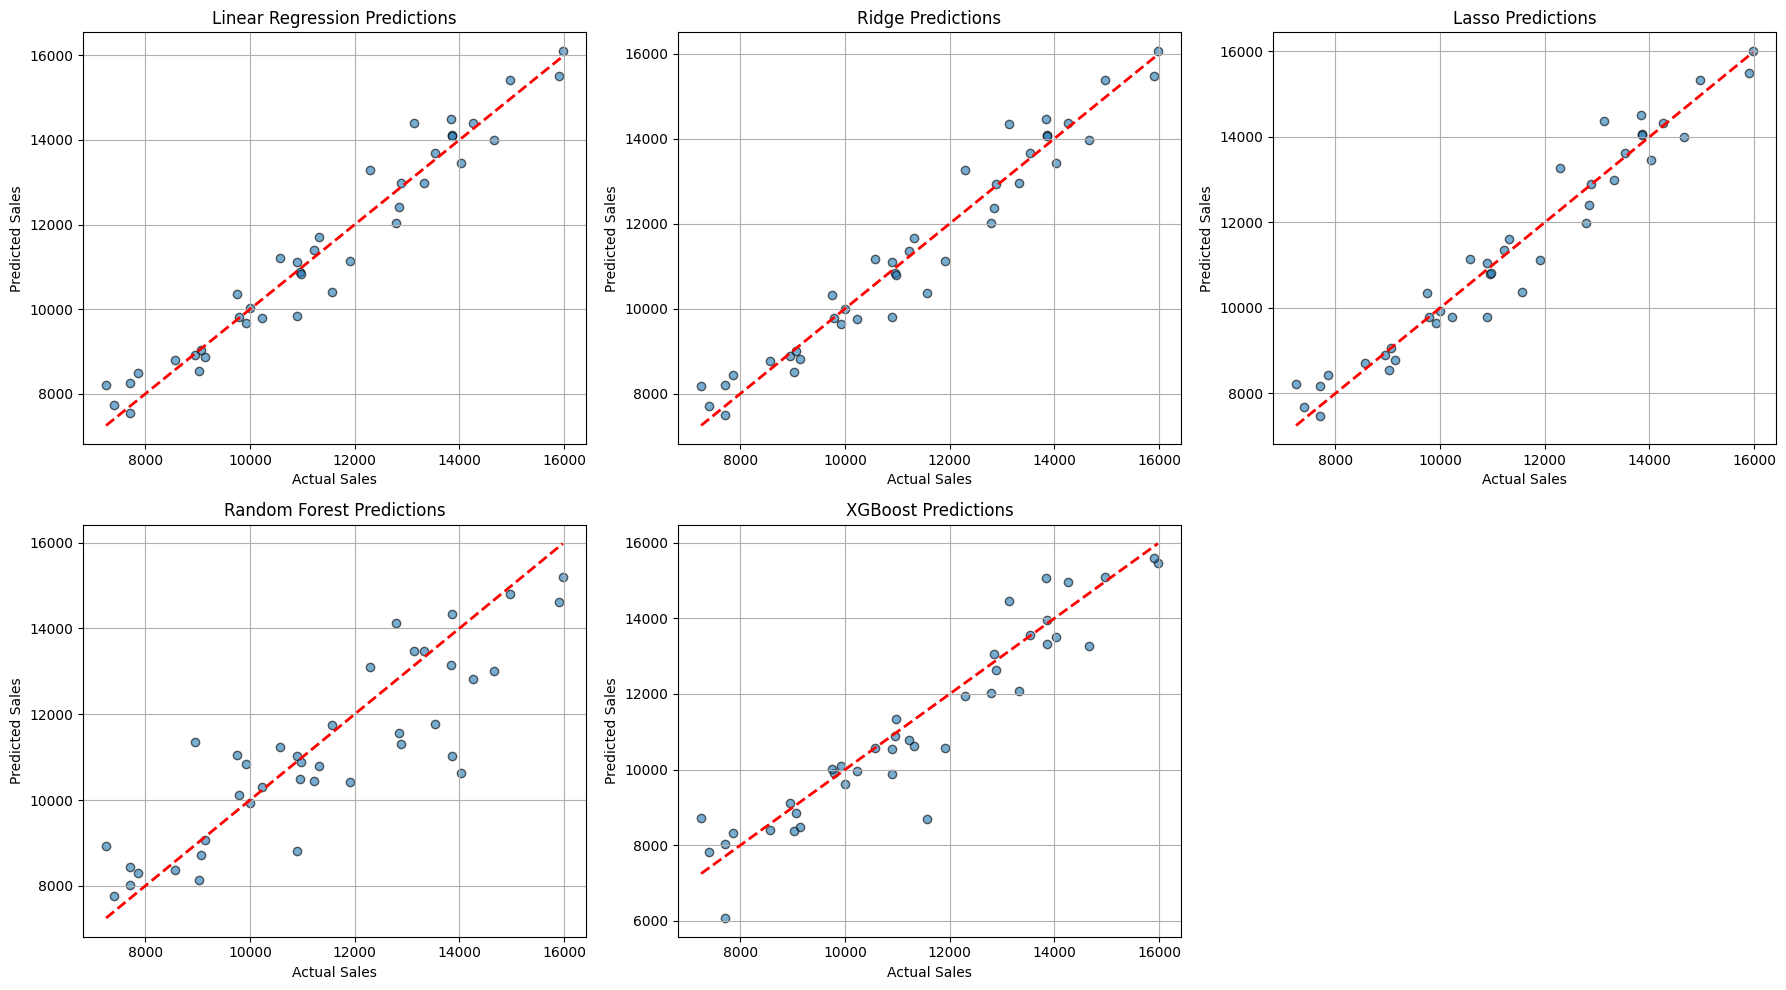

CPU times: user 739 ms, sys: 21.2 ms, total: 761 ms
Wall time: 759 ms


In [23]:
%%time
models_to_plot = {
    'Linear Regression': (y_test, y_pred_lin),
    'Ridge': (y_test, y_pred_ridge),
    'Lasso': (y_test, y_pred_lasso),
    'Random Forest': (y_test, y_pred_rf),
    'XGBoost': (y_test, y_pred_xgb)
}

# Create a 2x3 grid to accommodate 5 models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (name, (y_t, y_p)) in zip(axes, models_to_plot.items()):
    ax.scatter(y_t, y_p, alpha=0.6, edgecolors='k')
    ax.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], 'r--', linewidth=2)
    ax.set_title(f"{name} Predictions")
    ax.set_xlabel("Actual Sales")
    ax.set_ylabel("Predicted Sales")
    ax.grid(True)

# Turn off any unused subplot axes
for idx in range(len(models_to_plot), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

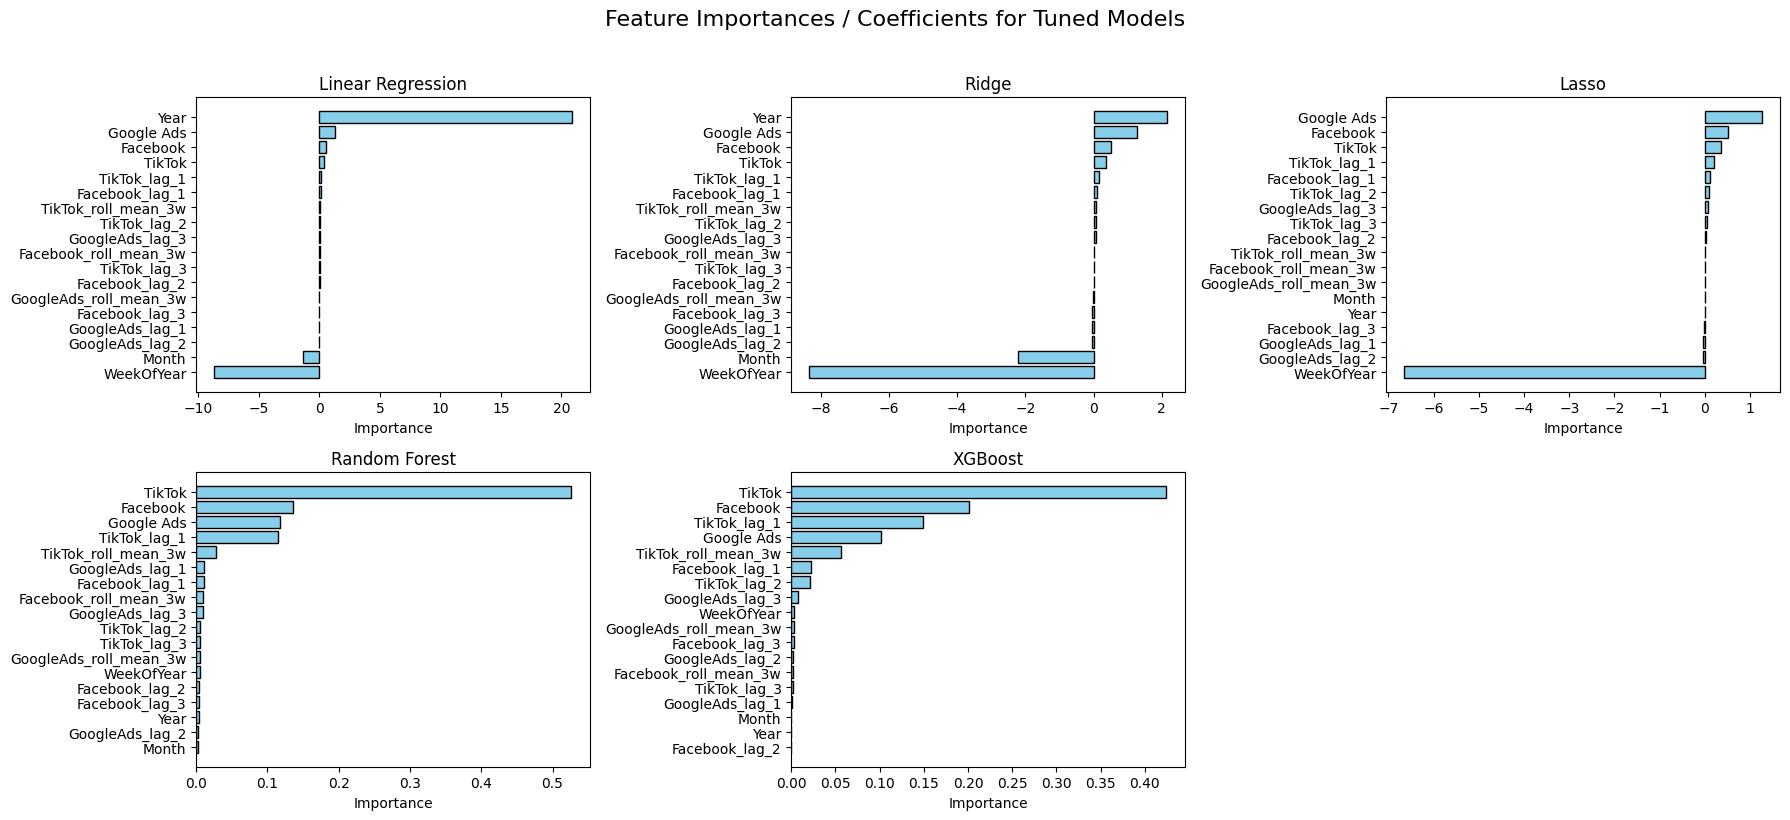

CPU times: user 2.01 s, sys: 21.8 ms, total: 2.03 s
Wall time: 3.39 s


In [25]:
%%time
# Helper function to extract importances or coefficients
import numpy as np
def get_feature_importances(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        return pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
    elif hasattr(model, 'coef_'):
        return pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.coef_
        }).sort_values('Importance', ascending=False)
    else:
        return pd.DataFrame(columns=['Feature', 'Importance'])

# Collect models and their names
tuned_models = {
    'Linear Regression': lin_reg,
    'Ridge': best_ridge,
    'Lasso': best_lasso,
    'Random Forest': best_rf,
    'XGBoost': best_xgb
}

# Plotting feature importances in a grid
n_mods = len(tuned_models)
n_cols = 3
n_rows = int(np.ceil(n_mods / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, (name, model) in enumerate(tuned_models.items()):
    ax = axes[idx]
    fi_df = get_feature_importances(model, X.columns)
    if fi_df.empty:
        ax.text(0.5, 0.5, 'No Importances', ha='center', va='center')
        ax.set_title(name)
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.barh(fi_df['Feature'], fi_df['Importance'], color='skyblue', edgecolor='black')
        ax.set_title(name)
        ax.invert_yaxis()
        ax.set_xlabel('Importance')

# Turn off unused subplots
for idx in range(n_mods, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Feature Importances / Coefficients for Tuned Models', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

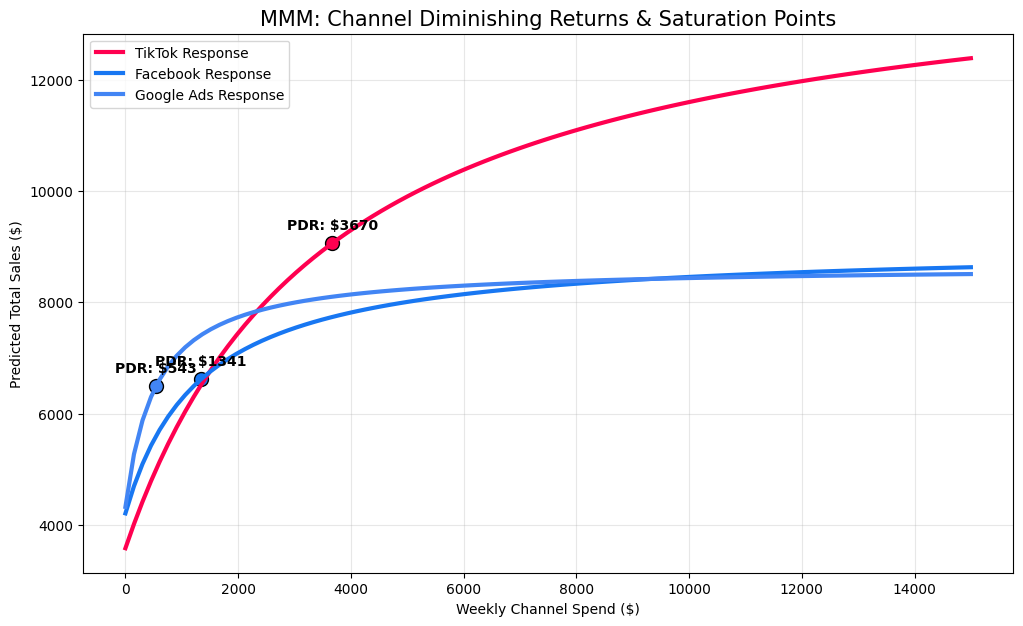

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import curve_fit

# 1. Load Data (Assumes marketing_mix.csv from your description)
df = pd.read_csv('/content/sample_data/marketing_mix.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# 2. Feature Engineering (Lags and Rolling Averages as described)
lag_weeks = [1, 2, 3]
for lag in lag_weeks:
    df[f'TikTok_lag_{lag}'] = df['TikTok'].shift(lag)
    df[f'Facebook_lag_{lag}'] = df['Facebook'].shift(lag)
    df[f'GoogleAds_lag_{lag}'] = df['Google Ads'].shift(lag)

rolling_window = 3
df['TikTok_roll_mean_3w'] = df['TikTok'].rolling(window=rolling_window).mean().shift(1)
df['Facebook_roll_mean_3w'] = df['Facebook'].rolling(window=rolling_window).mean().shift(1)
df['GoogleAds_roll_mean_3w'] = df['Google Ads'].rolling(window=rolling_window).mean().shift(1)

df = df.dropna().reset_index(drop=True)

# 3. Model Training
channels = ['TikTok', 'Facebook', 'Google Ads']
features = channels + [f'TikTok_lag_1', f'Facebook_lag_1', 'GoogleAds_lag_1',
                       'TikTok_roll_mean_3w', 'Facebook_roll_mean_3w', 'GoogleAds_roll_mean_3w']
X, y = df[features], df['Sales']
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# 4. Generate Response Curves
def hill_function(x, alpha, gamma, base):
    return alpha * x / (x + gamma) + base

# Helper function to get the correct feature name for lags/rolling means
def get_sanitized_channel_feature_name(channel_name, suffix):
    if channel_name == 'Google Ads':
        return 'GoogleAds' + suffix
    return channel_name + suffix

spend_points = np.linspace(0, 15000, 100)
X_mean = X.mean()
# Zero out ad features for baseline
for col in X_mean.index:
    # Using the same logic as feature generation to identify original ad spend columns
    if col in channels:
        X_mean[col] = 0
    elif any(get_sanitized_channel_feature_name(c, '') in col for c in channels): # Check for 'TikTok', 'Facebook', 'GoogleAds'
        X_mean[col] = 0


plt.figure(figsize=(12, 7))
colors = {'TikTok': '#ff0050', 'Facebook': '#1877f2', 'Google Ads': '#4285f4'}

for channel in channels:
    # Simulate varying spend for one channel while maintaining steady-state (lags/rolling)
    X_synth = pd.DataFrame([X_mean.values] * 100, columns=features)
    X_synth[channel] = spend_points
    X_synth[get_sanitized_channel_feature_name(channel, '_lag_1')] = spend_points
    X_synth[get_sanitized_channel_feature_name(channel, '_roll_mean_3w')] = spend_points

    y_raw = model.predict(X_synth)

    # Fit Hill function to find the 'elbow' (Point of Diminishing Returns)
    popt, _ = curve_fit(hill_function, spend_points, y_raw, p0=[max(y_raw), 2000, min(y_raw)])
    y_smooth = hill_function(spend_points, *popt)
    pdr_x = popt[1] # Half-saturation point is a proxy for the PDR

    plt.plot(spend_points, y_smooth, label=f'{channel} Response', color=colors[channel], lw=3)
    if pdr_x < max(spend_points):
        plt.scatter(pdr_x, hill_function(pdr_x, *popt), color=colors[channel], s=100, edgecolors='black')
        plt.annotate(f'PDR: ${pdr_x:.0f}', (pdr_x, hill_function(pdr_x, *popt)), xytext=(0,10),
                     textcoords="offset points", ha='center', fontweight='bold')

plt.title('MMM: Channel Diminishing Returns & Saturation Points', fontsize=15)
plt.xlabel('Weekly Channel Spend ($)')
plt.ylabel('Predicted Total Sales ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('diminishing_returns.png')
plt.show()